# Analysis: Gene Expression Inference from CODEX Markers

This notebook analyzes the integration results to:
1. **Infer gene expression** in cell types based on CODEX protein markers
2. **Validate inference accuracy** using shared RNA-protein features
3. **Quantify cell type-specific gene signatures** transferred from scRNA-seq

## Prerequisites
- Run `1_preprocessing.ipynb`, `2_integration.ipynb`, and `3_visualization.ipynb` first
- Ensure the save cell in notebook 3 was executed

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse, stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import pickle
import os
import json as json_module
import warnings
warnings.filterwarnings('ignore')

# Plotting defaults
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

print("Libraries loaded")

Libraries loaded


## Step 1: Load Data from Previous Notebooks

Load preprocessed data, integration results, and visualization outputs.

In [2]:
# Define directories
preprocess_dir = 'results/1_preprocessing'
integration_dir = 'results/2_integration'
visualization_dir = 'results/3_visualization'

# Check all directories exist
for name, d in [('Preprocessing', preprocess_dir), 
                ('Integration', integration_dir), 
                ('Visualization', visualization_dir)]:
    if not os.path.exists(d):
        raise FileNotFoundError(
            f"{name} results directory '{d}' not found. "
            f"Run the prerequisite notebooks first."
        )

print("Loading data from previous notebooks...")
print("=" * 60)

# 1. Load preprocessed AnnData objects
protein_adata = sc.read_h5ad(f'{preprocess_dir}/protein_adata.h5ad')
rna_adata = sc.read_h5ad(f'{preprocess_dir}/rna_adata.h5ad')
rna_adata_lognorm = sc.read_h5ad(f'{preprocess_dir}/rna_adata_lognorm.h5ad')
print(f"1. Preprocessed data:")
print(f"   Protein (CODEX): {protein_adata.shape[0]:,} cells x {protein_adata.shape[1]} markers")
print(f"   RNA: {rna_adata.shape[0]:,} cells x {rna_adata.shape[1]:,} genes")

# 2. Load integration results
with open(f'{integration_dir}/maxfuse_matching.pkl', 'rb') as f:
    matching_data = pickle.load(f)
full_matching = (matching_data['rna_indices'], 
                 matching_data['protein_indices'], 
                 matching_data['scores'])
print(f"2. MaxFuse matching: {len(full_matching[0]):,} matches")

# Load normalized arrays used for integration
rna_shared = np.load(f'{integration_dir}/rna_shared.npy')
rna_active = np.load(f'{integration_dir}/rna_active.npy')
protein_shared = np.load(f'{integration_dir}/protein_shared.npy')
protein_active = np.load(f'{integration_dir}/protein_active.npy')
print(f"3. Normalized arrays: shared={rna_shared.shape[1]}, active={rna_active.shape[1]}")

# Load correspondence table
correspondence_df = pd.read_csv(f'{integration_dir}/correspondence.csv')
print(f"4. RNA-Protein correspondence: {len(correspondence_df)} pairs")

# 3. Load visualization results
spatial_df = pd.read_csv(f'{visualization_dir}/spatial_cell_types.csv')
print(f"5. Spatial cell types: {len(spatial_df):,} cells")

# Load cluster annotations
with open(f'{visualization_dir}/cluster_annotations.json', 'r') as f:
    cluster_annotations = json_module.load(f)
print(f"6. Cluster annotations: {len(cluster_annotations)} clusters")

# Load aligned indices
aligned_rna_indices = np.load(f'{visualization_dir}/aligned_rna_indices.npy')
# Note: protein indices are in rna_to_prot_matches (many-to-one matching)
print(f"7. Aligned pairs: {len(aligned_rna_indices):,}")

# Load RNA-to-protein matches dictionary
with open(f'{visualization_dir}/rna_to_prot_matches.pkl', 'rb') as f:
    rna_to_prot_matches = pickle.load(f)

# Load CCA embeddings if available
try:
    rna_cca_scores = np.load(f'{visualization_dir}/rna_cca_scores.npy')
    prot_cca_scores = np.load(f'{visualization_dir}/prot_cca_scores.npy')
    print(f"8. CCA embeddings: {rna_cca_scores.shape}")
except FileNotFoundError:
    rna_cca_scores = None
    prot_cca_scores = None
    print("8. CCA embeddings: not found")

print("=" * 60)
print("\nData loading complete!")

Loading data from previous notebooks...
1. Preprocessed data:
   Protein (CODEX): 172,181 cells x 26 markers
   RNA: 9,374 cells x 18,626 genes
2. MaxFuse matching: 155,230 matches
3. Normalized arrays: shared=23, active=18626
4. RNA-Protein correspondence: 23 pairs
5. Spatial cell types: 155,230 cells
6. Cluster annotations: 20 clusters
7. Aligned pairs: 5,284
8. CCA embeddings: (5284, 20)

Data loading complete!


## Step 2: Data Summary and Quality Check

Verify the loaded data and summarize key statistics.

In [3]:
# Summarize cell types
print("Cell Type Distribution:")
print("=" * 40)
cell_type_col = 'cell_type_with_endo' if 'cell_type_with_endo' in spatial_df.columns else 'cell_type'
if cell_type_col in spatial_df.columns:
    cell_type_counts = spatial_df[cell_type_col].value_counts()
    for ct, count in cell_type_counts.items():
        pct = 100 * count / len(spatial_df)
        print(f"  {ct:25s}: {count:6,} ({pct:5.1f}%)")

# Matching quality
print("\n" + "=" * 40)
print("Matching Quality:")
print("=" * 40)
scores = np.array(full_matching[2])
print(f"  Total matches:  {len(scores):,}")
print(f"  Score range:    [{np.min(scores):.3f}, {np.max(scores):.3f}]")
print(f"  Mean score:     {np.mean(scores):.3f}")
print(f"  Median score:   {np.median(scores):.3f}")

# Coverage
n_unique_rna = len(np.unique(full_matching[0]))
n_unique_prot = len(np.unique(full_matching[1]))
print(f"\n  Unique RNA cells matched:     {n_unique_rna:,} / {rna_adata.shape[0]:,} ({100*n_unique_rna/rna_adata.shape[0]:.1f}%)")
print(f"  Unique Protein cells matched: {n_unique_prot:,} / {protein_adata.shape[0]:,} ({100*n_unique_prot/protein_adata.shape[0]:.1f}%)")

# RNA-Protein correspondence
print("\n" + "=" * 40)
print("Shared Features (RNA-Protein pairs):")
print("=" * 40)
for i, row in correspondence_df.iterrows():
    print(f"  {row['rna_gene']:12s} <-> {row['protein_marker']}")

Cell Type Distribution:
  B cell                   : 61,163 ( 39.4%)
  Monocyte/Macrophage      : 50,773 ( 32.7%)
  T cell                   : 22,475 ( 14.5%)
  Endothelial              : 12,269 (  7.9%)
  Other                    :  8,550 (  5.5%)

Matching Quality:
  Total matches:  155,230
  Score range:    [0.000, 0.955]
  Mean score:     0.481
  Median score:   0.493

  Unique RNA cells matched:     5,284 / 9,374 (56.4%)
  Unique Protein cells matched: 155,230 / 172,181 (90.2%)

Shared Features (RNA-Protein pairs):
  CD1C         <-> CD1c
  CD3E         <-> CD3e
  CD4          <-> CD4
  CD8A         <-> CD8
  ITGAX        <-> CD11c
  FUT4         <-> CD15
  MS4A1        <-> CD20
  CR2          <-> CD21
  PECAM1       <-> CD31
  CD34         <-> CD34
  CR1          <-> CD35
  CD44         <-> CD44
  PTPRC        <-> CD45
  CD68         <-> CD68
  LAMP1        <-> CD107a
  CD163        <-> CD163
  COL4A1       <-> CollagenIV
  FOXP3        <-> FoxP3
  HLA-DRA      <-> HLADR
  MKI67 

## Step 3: Gene Expression Inference by CODEX Marker

The key question: **Can we infer scRNA-seq gene expression from CODEX protein markers?**

For each matched RNA-Protein cell pair, we can:
1. Use the CODEX protein expression as a predictor
2. Transfer the RNA gene expression profile to the spatial location
3. Validate using shared features (genes with both RNA and protein measurements)

In [4]:
# Build a dataset linking CODEX markers to RNA expression
# IMPORTANT: Use UNIQUE RNA cells, not all match pairs

print("Building gene expression inference dataset...")
print("=" * 60)

# Clarify the data structure:
# - full_matching: ALL match pairs (RNA_idx, Prot_idx, score) - can have duplicates
# - aligned_rna_indices: UNIQUE RNA cells that have at least one match
# - rna_to_prot_matches: dict mapping each RNA cell to its matched protein cells

n_total_pairs = len(full_matching[0])
n_unique_rna = len(aligned_rna_indices)
avg_matches_per_rna = n_total_pairs / n_unique_rna

print(f"Total match pairs: {n_total_pairs:,}")
print(f"Unique RNA cells with matches: {n_unique_rna:,}")
print(f"Average protein matches per RNA cell: {avg_matches_per_rna:.1f}")

# Use unique RNA cells for inference
# For each RNA cell, average its matched protein cells
rna_indices_unique = aligned_rna_indices
n_samples = len(rna_indices_unique)

print(f"\nUsing {n_samples:,} unique RNA cells for analysis")

# Get RNA expression for matched cells (log-normalized from notebook 1)
# This uses the FILTERED gene set from preprocessing
rna_expr = rna_adata_lognorm.X[rna_indices_unique]
if sparse.issparse(rna_expr):
    rna_expr = rna_expr.toarray()

print(f"\nRNA expression matrix: {rna_expr.shape}")
print(f"  - {rna_expr.shape[0]} cells (unique matched RNA cells)")
print(f"  - {rna_expr.shape[1]} genes (filtered set from notebook 1)")

# Get averaged protein expression for each RNA cell
prot_expr_list = []
match_scores_list = []

for rna_idx in rna_indices_unique:
    matches = rna_to_prot_matches[rna_idx]
    prot_indices = [m[0] for m in matches]
    scores = [m[1] for m in matches]
    
    # Average protein expression across all matches for this RNA cell
    prot_vals = protein_adata.X[prot_indices]
    if sparse.issparse(prot_vals):
        prot_vals = prot_vals.toarray()
    prot_expr_list.append(prot_vals.mean(axis=0))
    match_scores_list.append(np.mean(scores))

prot_expr = np.array(prot_expr_list)
match_scores = np.array(match_scores_list)

print(f"Protein expression matrix: {prot_expr.shape}")
print(f"  - {prot_expr.shape[0]} cells (averaged per RNA cell)")
print(f"  - {prot_expr.shape[1]} markers (CODEX panel)")

# Create DataFrames for easier analysis
rna_df = pd.DataFrame(rna_expr, columns=rna_adata_lognorm.var_names)
prot_df = pd.DataFrame(prot_expr, columns=protein_adata.var_names)

# Add metadata
rna_df['_rna_idx'] = rna_indices_unique
rna_df['_match_score'] = match_scores

print(f"\nDatasets ready:")
print(f"  RNA genes available: {len(rna_adata_lognorm.var_names):,}")
print(f"  Protein markers available: {len(protein_adata.var_names)}")
print(f"  Samples for analysis: {n_samples:,}")

Building gene expression inference dataset...
Total match pairs: 155,230
Unique RNA cells with matches: 5,284
Average protein matches per RNA cell: 29.4

Using 5,284 unique RNA cells for analysis

RNA expression matrix: (5284, 18626)
  - 5284 cells (unique matched RNA cells)
  - 18626 genes (filtered set from notebook 1)
Protein expression matrix: (5284, 26)
  - 5284 cells (averaged per RNA cell)
  - 26 markers (CODEX panel)

Datasets ready:
  RNA genes available: 18,626
  Protein markers available: 26
  Samples for analysis: 5,284


## Step 4: Validate Inference Using Shared Features

We can validate the RNA-Protein matching by comparing expression of genes that have both RNA and protein measurements (shared features).

If matching is accurate, cells matched together should have **correlated** expression of these shared genes.

In [5]:
# Validate using shared features
print("Validating matching quality using shared features")
print("=" * 60)

# For each RNA-protein pair in correspondence, compare expression
validation_results = []

for _, row in correspondence_df.iterrows():
    rna_gene = row['rna_gene']
    prot_marker = row['protein_marker']
    
    if rna_gene not in rna_df.columns or prot_marker not in prot_df.columns:
        continue
    
    # Get expression values
    rna_vals = rna_df[rna_gene].values
    prot_vals = prot_df[prot_marker].values
    
    # Calculate correlation
    spearman_r, spearman_p = stats.spearmanr(rna_vals, prot_vals)
    pearson_r, pearson_p = stats.pearsonr(rna_vals, prot_vals)
    
    validation_results.append({
        'rna_gene': rna_gene,
        'protein_marker': prot_marker,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'n_samples': len(rna_vals),
        'rna_mean': np.mean(rna_vals),
        'prot_mean': np.mean(prot_vals),
    })

validation_df = pd.DataFrame(validation_results)

print("\nRNA-Protein Correlation for Shared Features:")
print("-" * 80)
print(f"{'RNA Gene':<12} {'Protein':<12} {'Spearman r':>12} {'p-value':>12} {'Pearson r':>12}")
print("-" * 80)

for _, row in validation_df.sort_values('spearman_r', ascending=False).iterrows():
    sig = "***" if row['spearman_p'] < 0.001 else "**" if row['spearman_p'] < 0.01 else "*" if row['spearman_p'] < 0.05 else ""
    print(f"{row['rna_gene']:<12} {row['protein_marker']:<12} {row['spearman_r']:>12.3f} {row['spearman_p']:>12.2e} {row['pearson_r']:>12.3f} {sig}")

print("-" * 80)
print(f"\nMean Spearman r: {validation_df['spearman_r'].mean():.3f}")
print(f"Median Spearman r: {validation_df['spearman_r'].median():.3f}")
print(f"Features with significant correlation (p<0.05): {(validation_df['spearman_p'] < 0.05).sum()}/{len(validation_df)}")

Validating matching quality using shared features

RNA-Protein Correlation for Shared Features:
--------------------------------------------------------------------------------
RNA Gene     Protein        Spearman r      p-value    Pearson r
--------------------------------------------------------------------------------
MS4A1        CD20                0.589     0.00e+00        0.579 ***
HLA-DRA      HLADR               0.442    2.41e-251        0.356 ***
CD163        CD163               0.437    5.33e-246        0.352 ***
CD68         CD68                0.422    1.95e-227        0.454 ***
VIM          Vimentin            0.401    6.53e-203        0.358 ***
CD3E         CD3e                0.388    6.93e-190        0.436 ***
CR2          CD21                0.338    1.12e-141        0.319 ***
PTPRC        CD45                0.249     1.26e-75        0.273 ***
CR1          CD35                0.241     7.19e-71        0.267 ***
PECAM1       CD31                0.200     1.08e-48     

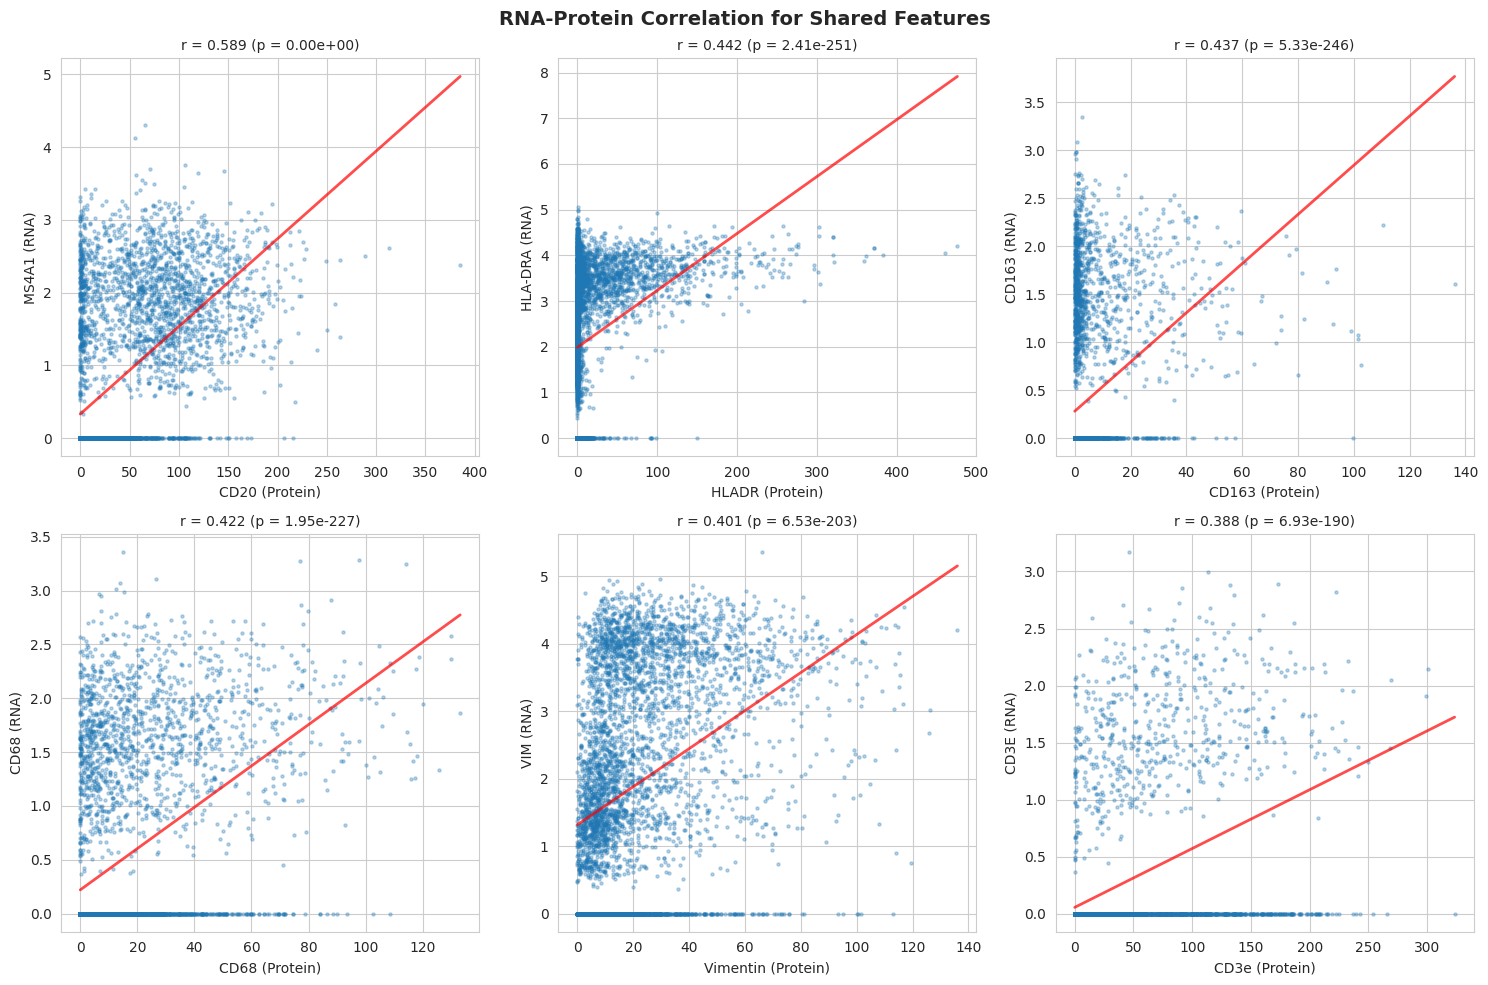

In [6]:
# Visualize RNA-Protein correlations for shared features
n_features = min(6, len(validation_df))
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

# Select top features by correlation
top_features = validation_df.nlargest(n_features, 'spearman_r')

for ax, (_, row) in zip(axes, top_features.iterrows()):
    rna_gene = row['rna_gene']
    prot_marker = row['protein_marker']
    
    rna_vals = rna_df[rna_gene].values
    prot_vals = prot_df[prot_marker].values
    
    # Subsample for plotting
    n_plot = min(5000, len(rna_vals))
    idx = np.random.choice(len(rna_vals), n_plot, replace=False)
    
    ax.scatter(prot_vals[idx], rna_vals[idx], alpha=0.3, s=5)
    ax.set_xlabel(f'{prot_marker} (Protein)', fontsize=10)
    ax.set_ylabel(f'{rna_gene} (RNA)', fontsize=10)
    ax.set_title(f"r = {row['spearman_r']:.3f} (p = {row['spearman_p']:.2e})", fontsize=10)
    
    # Add regression line
    z = np.polyfit(prot_vals, rna_vals, 1)
    p = np.poly1d(z)
    x_line = np.linspace(prot_vals.min(), prot_vals.max(), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2, alpha=0.7)

# Hide extra axes
for ax in axes[n_features:]:
    ax.axis('off')

plt.suptitle('RNA-Protein Correlation for Shared Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/3_visualization/shared_feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 5: Cell Type-Specific Gene Expression Inference

Now we can infer gene expression profiles for each cell type identified from the integration.
This transfers the rich transcriptomic information from scRNA-seq to the spatial CODEX context.

In [7]:
# Get cell type for each matched cell
cell_type_col = 'cell_type_with_endo' if 'cell_type_with_endo' in spatial_df.columns else 'cell_type'

# Build RNA index to cell type mapping
rna_to_celltype = {}
for _, row in spatial_df.iterrows():
    rna_idx = row['rna_idx']
    ct = row[cell_type_col] if cell_type_col in row else 'Unknown'
    rna_to_celltype[rna_idx] = ct

# Assign cell types to our matched dataset
cell_types = [rna_to_celltype.get(idx, 'Unknown') for idx in rna_indices_unique]
rna_df['cell_type'] = cell_types

print("Cell type distribution in matched dataset:")
print(rna_df['cell_type'].value_counts())

Cell type distribution in matched dataset:
cell_type
B cell                 2322
Monocyte/Macrophage    1407
T cell                 1090
Endothelial             265
Other                   200
Name: count, dtype: int64


In [8]:
# Calculate mean gene expression per cell type
n_top_genes = 500
gene_cols = [c for c in rna_df.columns if not c.startswith('_') and c != 'cell_type']
gene_vars = rna_df[gene_cols].var()
top_genes = gene_vars.nlargest(n_top_genes).index.tolist()

print(f"Analyzing top {n_top_genes} variable genes")
print("=" * 60)

# Calculate mean expression per cell type
celltype_expression = {}
celltype_stats = []

for ct in rna_df['cell_type'].unique():
    if ct == 'Unknown':
        continue
    
    ct_mask = rna_df['cell_type'] == ct
    n_cells = ct_mask.sum()
    
    if n_cells < 10:
        continue
    
    ct_expr = rna_df.loc[ct_mask, top_genes].mean()
    celltype_expression[ct] = ct_expr
    
    celltype_stats.append({
        'cell_type': ct,
        'n_cells': n_cells,
        'mean_expr': ct_expr.mean(),
        'n_detected': (ct_expr > 0.1).sum()
    })

celltype_stats_df = pd.DataFrame(celltype_stats)
print("\nCell type expression statistics:")
print(celltype_stats_df.to_string(index=False))

# Create expression matrix
celltype_expr_matrix = pd.DataFrame(celltype_expression).T
print(f"\nCell type expression matrix: {celltype_expr_matrix.shape}")

Analyzing top 500 variable genes

Cell type expression statistics:
          cell_type  n_cells  mean_expr  n_detected
             B cell     2322   1.078728         487
Monocyte/Macrophage     1407   1.327355         492
             T cell     1090   1.066060         484
        Endothelial      265   1.239389         499
              Other      200   1.152292         500

Cell type expression matrix: (5, 500)



B cell marker genes (top 5):
  CD79A: FC = 1.87
  BANK1: FC = 1.83
  MS4A1: FC = 1.82
  TNFRSF13C: FC = 1.79
  HLA-DQA1: FC = 1.79

Monocyte/Macrophage marker genes (top 5):
  S100A8: FC = 2.67
  S100A9: FC = 2.64
  CXCL8: FC = 2.64
  LYZ: FC = 2.64
  EREG: FC = 2.63

T cell marker genes (top 5):
  GNLY: FC = 2.79
  KLRD1: FC = 2.69
  CCL5: FC = 2.66
  CD7: FC = 2.52
  IL32: FC = 2.51

Endothelial marker genes (top 5):
  SERPINB2: FC = 2.28
  S100A8: FC = 2.21
  MAFB: FC = 2.19
  S100A12: FC = 2.19
  LYZ: FC = 2.17

Other marker genes (top 5):
  IL7R: FC = 1.52
  NR4A1: FC = 1.29
  CD14: FC = 1.27
  IGKC: FC = 1.25
  CST3: FC = 1.24


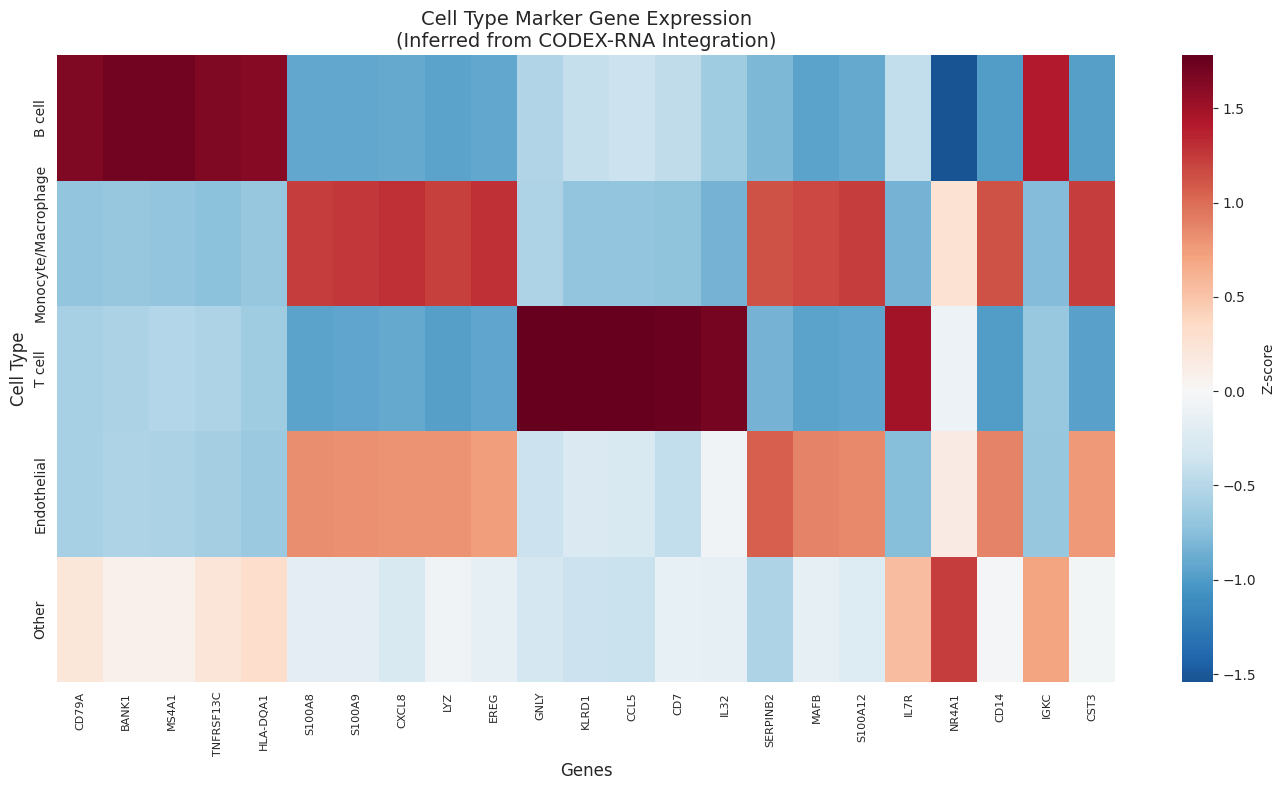

In [9]:
# Identify marker genes for each cell type
marker_genes = {}
all_other_mean = rna_df[top_genes].mean()

for ct, ct_expr in celltype_expression.items():
    fold_change = (ct_expr + 0.1) / (all_other_mean + 0.1)
    top_markers = fold_change.nlargest(20).index.tolist()
    marker_genes[ct] = top_markers
    
    print(f"\n{ct} marker genes (top 5):")
    for gene in top_markers[:5]:
        print(f"  {gene}: FC = {fold_change[gene]:.2f}")

# Create combined marker list
all_markers = []
for ct, markers in marker_genes.items():
    all_markers.extend(markers[:5])
all_markers = list(dict.fromkeys(all_markers))

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))

heatmap_data = celltype_expr_matrix[all_markers]
heatmap_zscore = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()

sns.heatmap(heatmap_zscore, cmap='RdBu_r', center=0, 
            xticklabels=True, yticklabels=True, ax=ax,
            cbar_kws={'label': 'Z-score'})
ax.set_xlabel('Genes', fontsize=12)
ax.set_ylabel('Cell Type', fontsize=12)
ax.set_title('Cell Type Marker Gene Expression\n(Inferred from CODEX-RNA Integration)', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig('results/3_visualization/celltype_markers_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 5b: SH2B3 Gene and Pathway Analysis

**SH2B3** (also known as LNK) is an adaptor protein that negatively regulates cytokine signaling.

Key pathways involving SH2B3:
- **JAK-STAT signaling** - SH2B3 inhibits JAK2 activation
- **Cytokine receptor signaling** - Regulates EPO, TPO, and other cytokine responses
- **Hematopoiesis** - Controls stem cell self-renewal and lineage commitment
- **Immune cell activation** - Modulates T cell and B cell receptor signaling

In [14]:
# SH2B3 and related pathway gene analysis
print("=" * 70)
print("SH2B3 GENE AND PATHWAY ANALYSIS")
print("=" * 70)

# Define SH2B3 and related pathway genes
sh2b3_pathway = {
    'SH2B3': 'SH2B3/LNK - Adaptor protein, negative regulator of JAK-STAT',
    # JAK-STAT pathway
    'JAK1': 'Janus kinase 1',
    'JAK2': 'Janus kinase 2 (directly inhibited by SH2B3)',
    'JAK3': 'Janus kinase 3',
    'TYK2': 'Tyrosine kinase 2',
    'STAT1': 'Signal transducer and activator of transcription 1',
    'STAT3': 'Signal transducer and activator of transcription 3',
    'STAT5A': 'STAT5A - downstream of JAK2',
    'STAT5B': 'STAT5B - downstream of JAK2',
    # Cytokine receptors
    'EPOR': 'Erythropoietin receptor',
    'MPL': 'Thrombopoietin receptor',
    'CSF2RB': 'GM-CSF receptor beta',
    'IL2RG': 'Common gamma chain (IL2, IL7, IL15 signaling)',
    # Related adaptors
    'SH2B1': 'SH2B family member 1',
    'SH2B2': 'SH2B family member 2 (APS)',
    # Downstream targets
    'SOCS1': 'Suppressor of cytokine signaling 1',
    'SOCS3': 'Suppressor of cytokine signaling 3',
    'CISH': 'Cytokine-inducible SH2 protein',
}

# Check which genes are available
available_genes = []
missing_genes = []

for gene in sh2b3_pathway.keys():
    if gene in rna_df.columns:
        available_genes.append(gene)
    else:
        missing_genes.append(gene)

print(f"\nPathway genes available: {len(available_genes)}/{len(sh2b3_pathway)}")
print(f"Available: {available_genes}")
if missing_genes:
    print(f"Missing: {missing_genes}")

# Check if SH2B3 itself is available
if 'SH2B3' in available_genes:
    print(f"\n{'='*50}")
    print("SH2B3 Expression Analysis")
    print('='*50)
    
    sh2b3_expr = rna_df['SH2B3'].values
    print(f"\nOverall SH2B3 expression:")
    print(f"  Mean:   {np.mean(sh2b3_expr):.4f}")
    print(f"  Median: {np.median(sh2b3_expr):.4f}")
    print(f"  Std:    {np.std(sh2b3_expr):.4f}")
    print(f"  % expressing (>0.1): {100*(sh2b3_expr > 0.1).mean():.1f}%")
    
    # Expression by cell type
    print(f"\nSH2B3 expression by cell type:")
    for ct in sorted(rna_df['cell_type'].unique()):
        if ct == 'Unknown':
            continue
        ct_expr = rna_df.loc[rna_df['cell_type'] == ct, 'SH2B3'].values
        if len(ct_expr) > 0:
            print(f"  {ct:25s}: mean={np.mean(ct_expr):.3f}, "
                  f"% expressing={100*(ct_expr > 0.1).mean():.1f}%")
else:
    print("\n*** SH2B3 not found in RNA data ***")
    print("This gene may have been filtered out during preprocessing")
    print("or may not be well-detected in this scRNA-seq dataset.")

# Analyze available pathway genes
if len(available_genes) > 1:
    print(f"\n{'='*50}")
    print("Pathway Gene Expression by Cell Type")
    print('='*50)
    
    # Create pathway expression matrix
    pathway_expr = rna_df[available_genes].copy()
    pathway_expr['cell_type'] = rna_df['cell_type']
    
    # Mean expression per cell type
    pathway_by_celltype = pathway_expr.groupby('cell_type')[available_genes].mean()
    
    # Remove Unknown if present
    if 'Unknown' in pathway_by_celltype.index:
        pathway_by_celltype = pathway_by_celltype.drop('Unknown')
    
    print("\nMean expression per cell type:")
    print(pathway_by_celltype.round(3).to_string())


SH2B3 GENE AND PATHWAY ANALYSIS

Pathway genes available: 17/18
Available: ['SH2B3', 'JAK1', 'JAK2', 'JAK3', 'TYK2', 'STAT1', 'STAT3', 'STAT5A', 'STAT5B', 'EPOR', 'CSF2RB', 'IL2RG', 'SH2B1', 'SH2B2', 'SOCS1', 'SOCS3', 'CISH']
Missing: ['MPL']

SH2B3 Expression Analysis

Overall SH2B3 expression:
  Mean:   0.2688
  Median: 0.0000
  Std:    0.5122
  % expressing (>0.1): 24.5%

SH2B3 expression by cell type:
  B cell                   : mean=0.172, % expressing=17.9%
  Endothelial              : mean=0.438, % expressing=35.5%
  Monocyte/Macrophage      : mean=0.554, % expressing=47.5%
  Other                    : mean=0.268, % expressing=27.0%
  T cell                   : mean=0.067, % expressing=5.5%

Pathway Gene Expression by Cell Type

Mean expression per cell type:
                     SH2B3   JAK1   JAK2   JAK3   TYK2  STAT1  STAT3  STAT5A  STAT5B   EPOR  CSF2RB  IL2RG  SH2B1  SH2B2  SOCS1  SOCS3   CISH
cell_type                                                                       

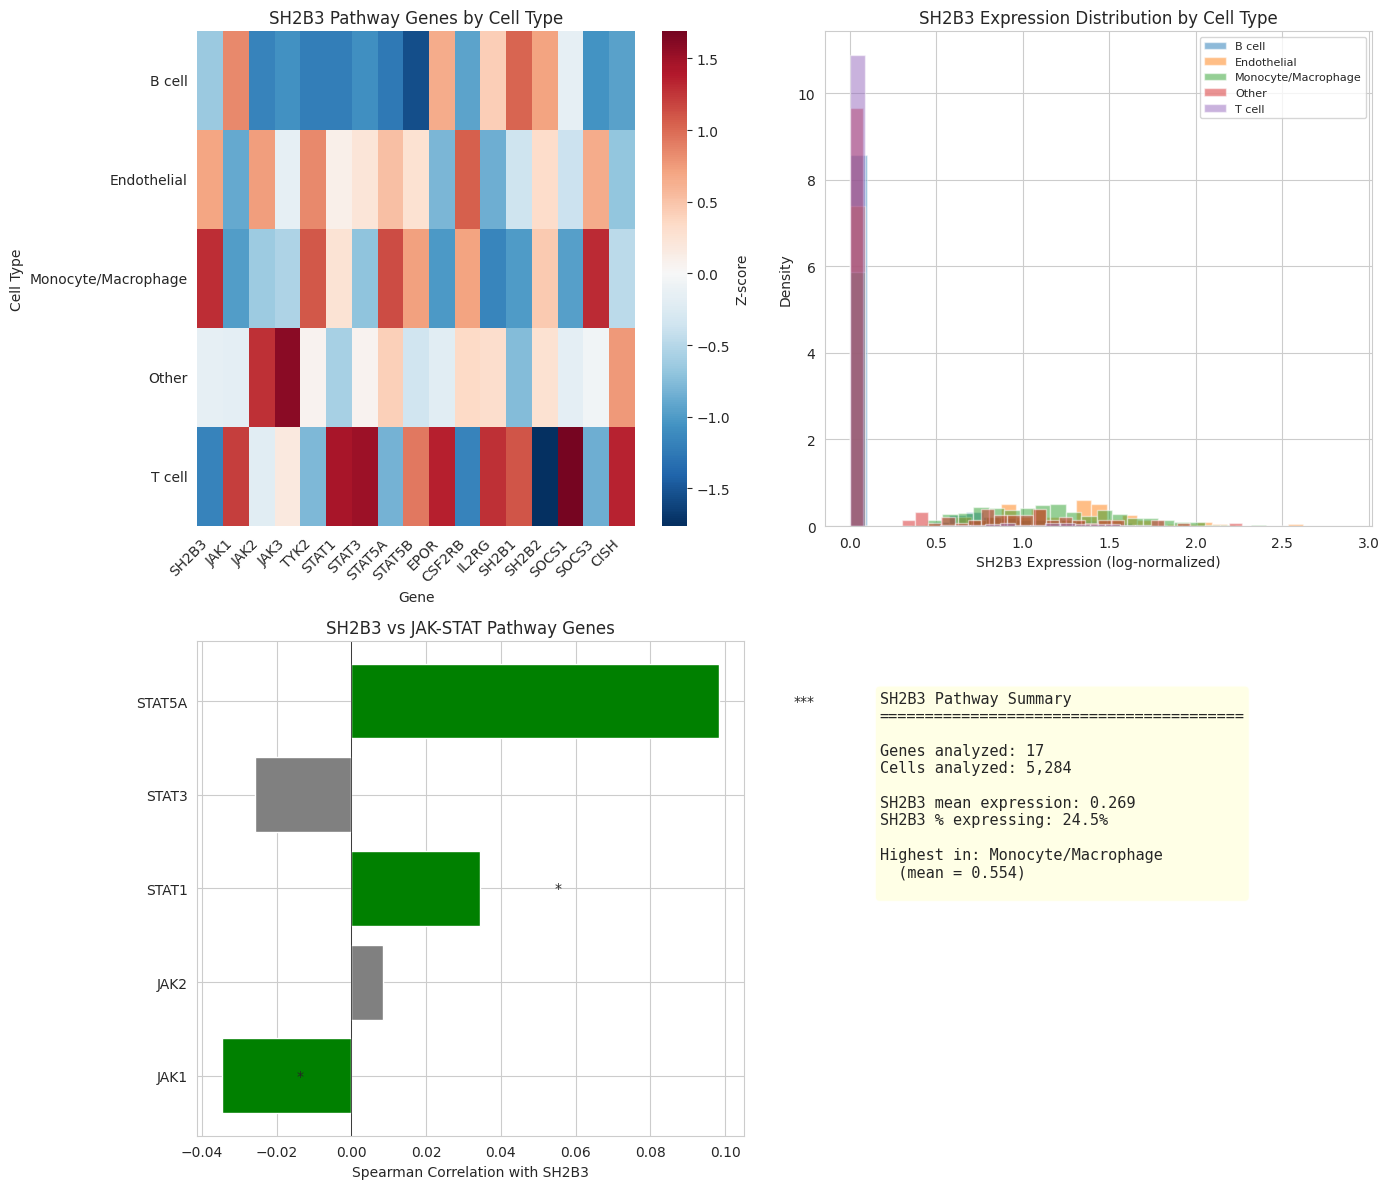


SH2B3 pathway analysis complete


In [15]:
# Visualize SH2B3 pathway expression
if len(available_genes) >= 3:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Panel 1: Pathway gene heatmap by cell type
    ax = axes[0, 0]
    if len(pathway_by_celltype) > 0:
        # Z-score normalize
        pathway_zscore = (pathway_by_celltype - pathway_by_celltype.mean()) / pathway_by_celltype.std()
        sns.heatmap(pathway_zscore, cmap='RdBu_r', center=0, ax=ax,
                    xticklabels=True, yticklabels=True,
                    cbar_kws={'label': 'Z-score'})
        ax.set_title('SH2B3 Pathway Genes by Cell Type', fontsize=12)
        ax.set_xlabel('Gene')
        ax.set_ylabel('Cell Type')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Panel 2: SH2B3 expression distribution
    ax = axes[0, 1]
    if 'SH2B3' in available_genes:
        for ct in sorted(rna_df['cell_type'].unique()):
            if ct == 'Unknown':
                continue
            ct_expr = rna_df.loc[rna_df['cell_type'] == ct, 'SH2B3'].values
            if len(ct_expr) > 10:
                ax.hist(ct_expr, bins=30, alpha=0.5, label=ct, density=True)
        ax.set_xlabel('SH2B3 Expression (log-normalized)')
        ax.set_ylabel('Density')
        ax.set_title('SH2B3 Expression Distribution by Cell Type')
        ax.legend(loc='upper right', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'SH2B3 not available', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('SH2B3 Expression')
    
    # Panel 3: JAK-STAT genes correlation with SH2B3
    ax = axes[1, 0]
    jak_stat_genes = [g for g in ['JAK1', 'JAK2', 'STAT1', 'STAT3', 'STAT5A'] if g in available_genes]
    if 'SH2B3' in available_genes and len(jak_stat_genes) > 0:
        correlations = []
        for gene in jak_stat_genes:
            r, p = stats.spearmanr(rna_df['SH2B3'], rna_df[gene])
            correlations.append({'gene': gene, 'r': r, 'p': p})
        corr_df = pd.DataFrame(correlations)
        
        colors = ['green' if p < 0.05 else 'gray' for p in corr_df['p']]
        bars = ax.barh(corr_df['gene'], corr_df['r'], color=colors)
        ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
        ax.set_xlabel('Spearman Correlation with SH2B3')
        ax.set_title('SH2B3 vs JAK-STAT Pathway Genes')
        
        # Add significance markers
        for i, (_, row) in enumerate(corr_df.iterrows()):
            sig = '***' if row['p'] < 0.001 else '**' if row['p'] < 0.01 else '*' if row['p'] < 0.05 else ''
            ax.text(row['r'] + 0.02, i, sig, va='center')
    else:
        ax.text(0.5, 0.5, 'Insufficient genes for correlation', ha='center', va='center', transform=ax.transAxes)
    
    # Panel 4: Summary statistics table
    ax = axes[1, 1]
    ax.axis('off')
    
    summary_text = "SH2B3 Pathway Summary\n" + "=" * 40 + "\n\n"
    summary_text += f"Genes analyzed: {len(available_genes)}\n"
    summary_text += f"Cells analyzed: {len(rna_df):,}\n\n"
    
    if 'SH2B3' in available_genes:
        sh2b3_mean = rna_df['SH2B3'].mean()
        sh2b3_pct = 100 * (rna_df['SH2B3'] > 0.1).mean()
        summary_text += f"SH2B3 mean expression: {sh2b3_mean:.3f}\n"
        summary_text += f"SH2B3 % expressing: {sh2b3_pct:.1f}%\n\n"
        
        # Top expressing cell type
        ct_means = rna_df.groupby('cell_type')['SH2B3'].mean()
        ct_means = ct_means.drop('Unknown', errors='ignore')
        if len(ct_means) > 0:
            top_ct = ct_means.idxmax()
            summary_text += f"Highest in: {top_ct}\n"
            summary_text += f"  (mean = {ct_means[top_ct]:.3f})\n"
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('results/3_visualization/sh2b3_pathway_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Insufficient pathway genes available for visualization")

print("\n" + "=" * 70)
print("SH2B3 pathway analysis complete")
print("=" * 70)


## Step 5c: Spatial Mapping of Inferred Gene Expression

Map the inferred RNA gene expression back onto CODEX spatial coordinates.
This visualizes where specific genes are expressed in the tissue.

In [18]:
# Map inferred gene expression onto CODEX spatial coordinates
print("=" * 70)
print("SPATIAL MAPPING OF INFERRED GENE EXPRESSION")
print("=" * 70)

# Build spatial expression dataframe
# For each RNA cell, get its matched protein cells and their spatial coordinates
spatial_expr_records = []

for i, rna_idx in enumerate(rna_indices_unique):
    # Get gene expression for this RNA cell
    rna_row = rna_df.iloc[i]
    
    # Get matched protein cells and their coordinates
    matches = rna_to_prot_matches[rna_idx]
    
    for prot_idx, score in matches:
        record = {
            'rna_idx': rna_idx,
            'protein_idx': prot_idx,
            'x': protein_adata.obs['X_centroid'].values[prot_idx],
            'y': protein_adata.obs['Y_centroid'].values[prot_idx],
            'match_score': score,
            'cell_type': rna_row['cell_type'],
        }
        
        # Add expression for key genes
        genes_to_map = ['SH2B3', 'JAK2', 'STAT3', 'STAT5A', 'CD3E', 'MS4A1', 'CD68', 'PECAM1']
        for gene in genes_to_map:
            if gene in rna_df.columns:
                record[gene] = rna_row[gene]
        
        spatial_expr_records.append(record)

spatial_expr_df = pd.DataFrame(spatial_expr_records)
print(f"Spatial expression mapping: {len(spatial_expr_df):,} cells")
print(f"Unique spatial locations: {spatial_expr_df[['x', 'y']].drop_duplicates().shape[0]:,}")

# List available genes for mapping
mapped_genes = [g for g in ['SH2B3', 'JAK2', 'STAT3', 'STAT5A', 'CD3E', 'MS4A1', 'CD68', 'PECAM1'] 
                if g in spatial_expr_df.columns]
print(f"\nGenes available for spatial mapping: {mapped_genes}")


SPATIAL MAPPING OF INFERRED GENE EXPRESSION
Spatial expression mapping: 155,230 cells
Unique spatial locations: 155,230

Genes available for spatial mapping: ['SH2B3', 'JAK2', 'STAT3', 'STAT5A', 'CD3E', 'MS4A1', 'CD68', 'PECAM1']


Subsampled to 50,000 points for visualization


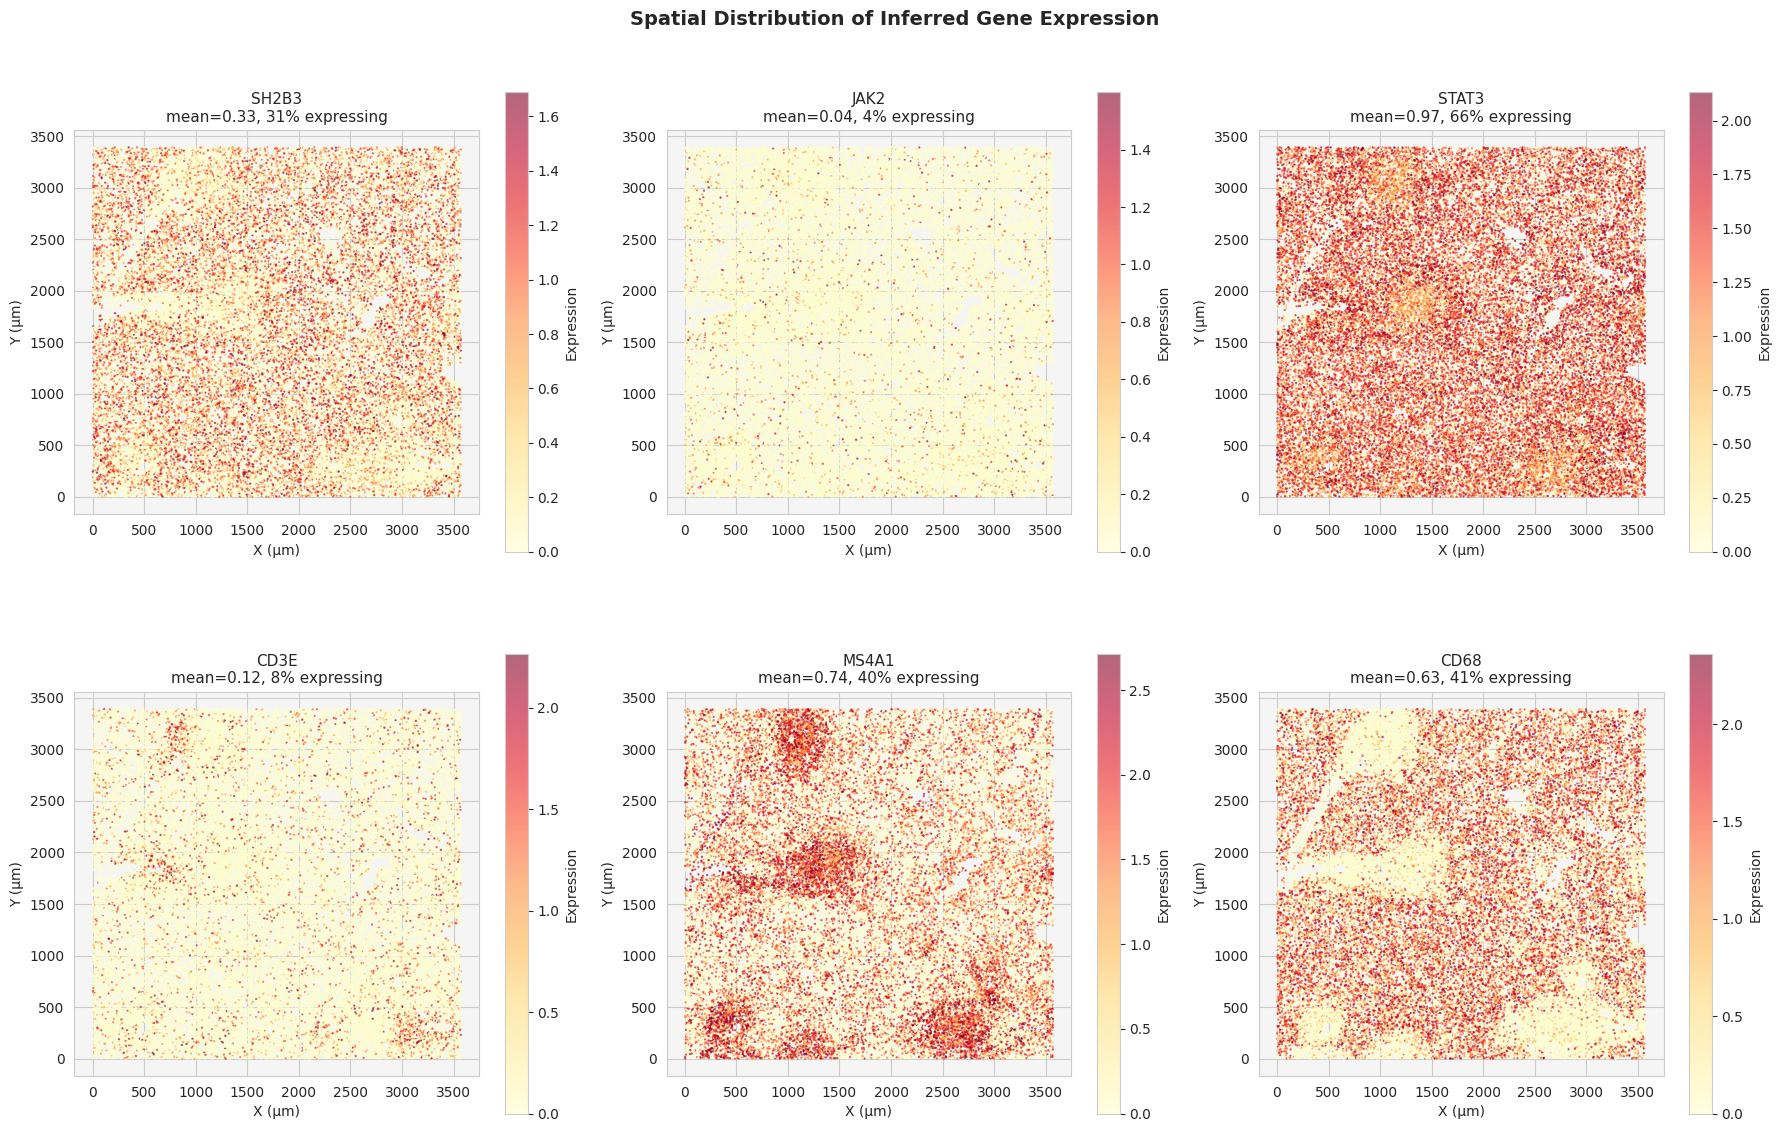

In [28]:
# Spatial scatterplots of inferred gene expression
# Subsample for visualization if needed
np.random.seed(42)
max_points = 50000
if len(spatial_expr_df) > max_points:
    plot_df = spatial_expr_df.sample(n=max_points)
    print(f"Subsampled to {max_points:,} points for visualization")
else:
    plot_df = spatial_expr_df

# Create spatial plots for key genes
genes_to_plot = [g for g in ['SH2B3', 'JAK2', 'STAT3', 'CD3E', 'MS4A1', 'CD68'] 
                 if g in plot_df.columns]

if len(genes_to_plot) > 0:
    n_genes = len(genes_to_plot)
    n_cols = 3
    n_rows = (n_genes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    axes = axes.flatten() if n_genes > 1 else [axes]
    
    for ax, gene in zip(axes, genes_to_plot):
        # Get expression values
        expr_vals = plot_df[gene].values
        
        # Set vmax to 95th percentile of expressing cells
        vmax = np.percentile(expr_vals[expr_vals > 0], 95) if (expr_vals > 0).any() else 1
        
        # Create scatter plot with YlOrRd colormap (visible on white)
        scatter = ax.scatter(
            plot_df['x'], plot_df['y'],
            c=expr_vals,
            s=0.5,
            alpha=0.6,
            cmap='YlOrRd',  # Yellow-Orange-Red, visible at low values
            vmin=0,
            vmax=vmax
        )
        
        ax.set_xlabel('X (µm)', fontsize=10)
        ax.set_ylabel('Y (µm)', fontsize=10)
        ax.set_facecolor('#f5f5f5')  # Light gray background for contrast
        
        # Add expression statistics to title
        mean_expr = expr_vals.mean()
        pct_expressing = 100 * (expr_vals > 0.1).mean()
        ax.set_title(f'{gene}\nmean={mean_expr:.2f}, {pct_expressing:.0f}% expressing', fontsize=11)
        ax.set_aspect('equal')
        plt.colorbar(scatter, ax=ax, label='Expression', shrink=0.8)
    
    # Hide empty axes
    for ax in axes[n_genes:]:
        ax.axis('off')
    
    plt.suptitle('Spatial Distribution of Inferred Gene Expression', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/3_visualization/spatial_gene_expression.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No genes available for spatial plotting")


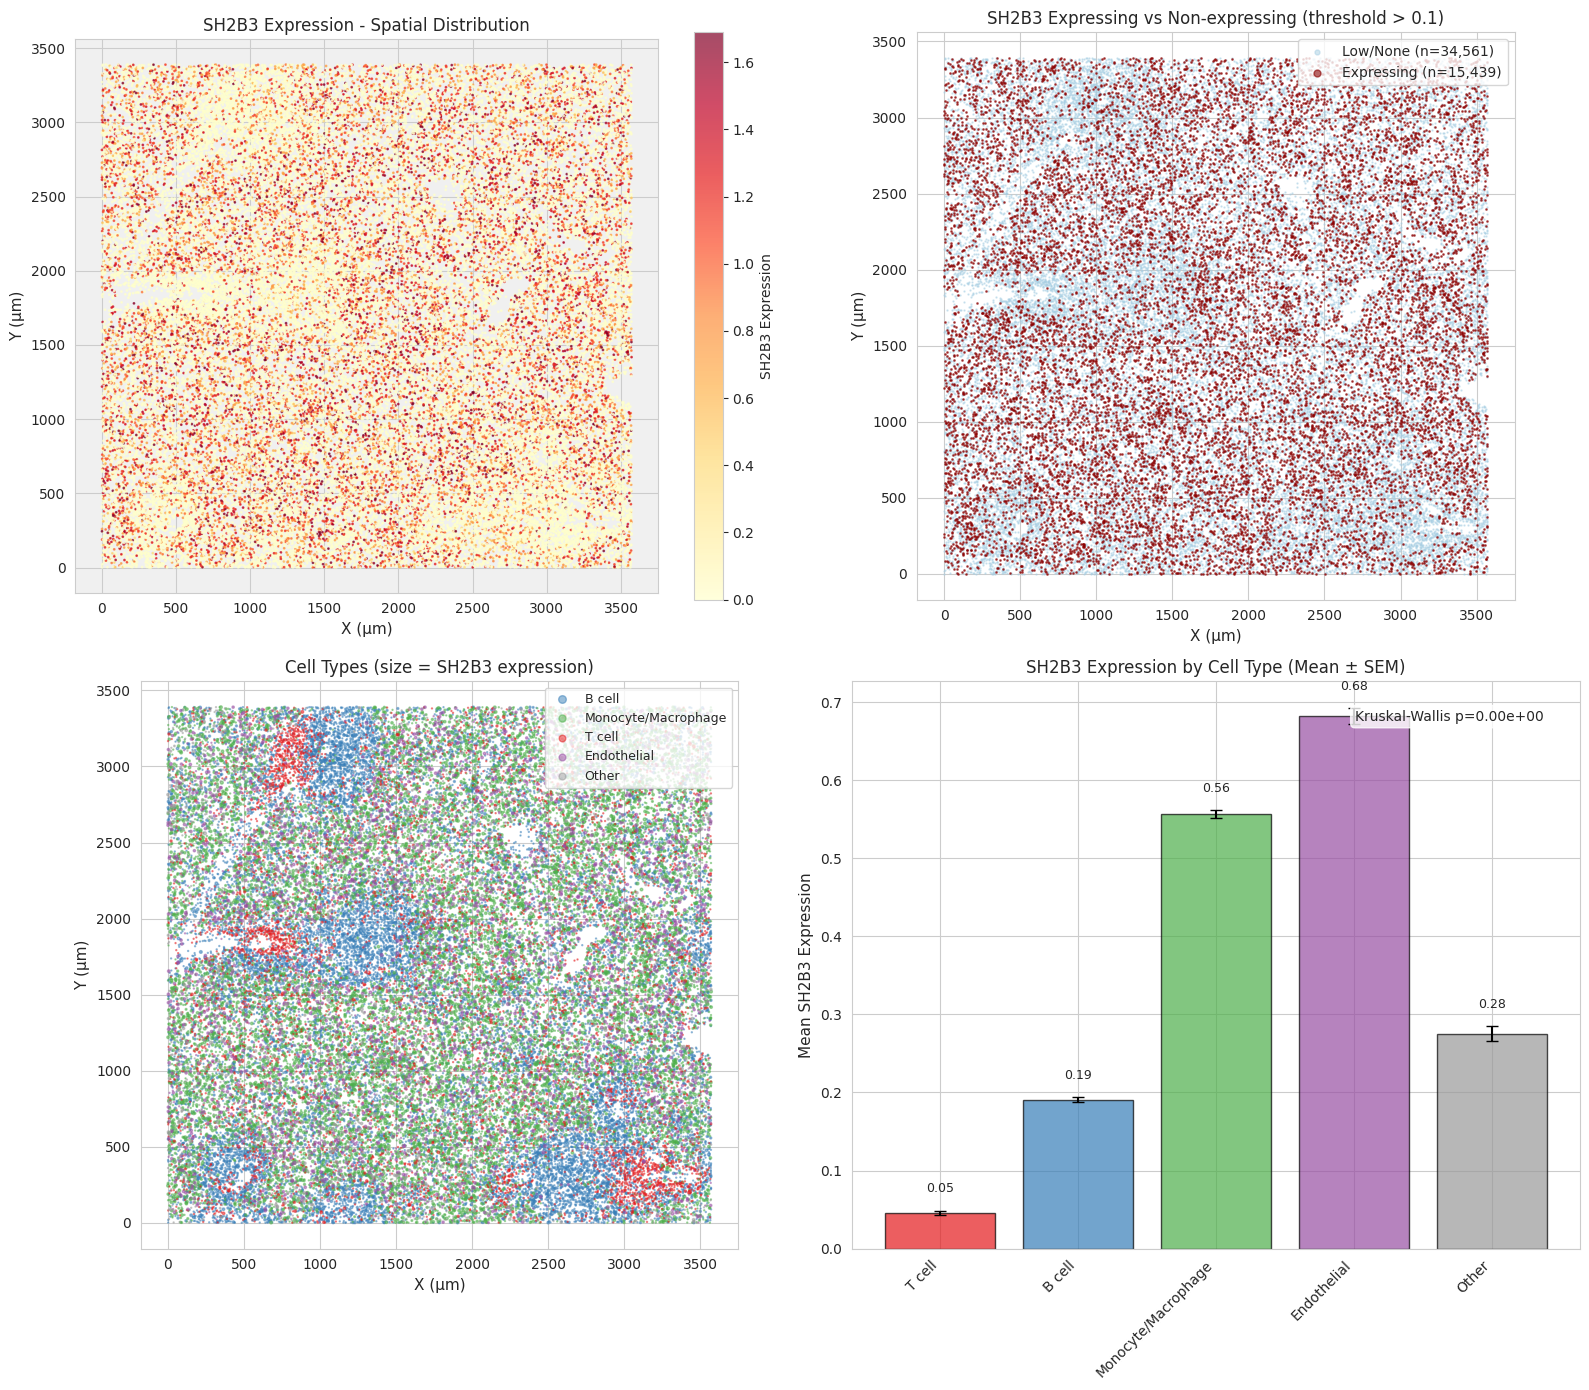

SH2B3 Spatial Expression Summary:
T cell                   : mean=0.044, median=0.000, 4.2% expressing, n=22,475
B cell                   : mean=0.190, median=0.000, 21.1% expressing, n=61,163
Monocyte/Macrophage      : mean=0.553, median=0.000, 49.0% expressing, n=50,773
Endothelial              : mean=0.690, median=1.096, 56.0% expressing, n=12,269
Other                    : mean=0.273, median=0.000, 26.4% expressing, n=8,550
PATHWAY GENE EXPRESSION BY CELL TYPE


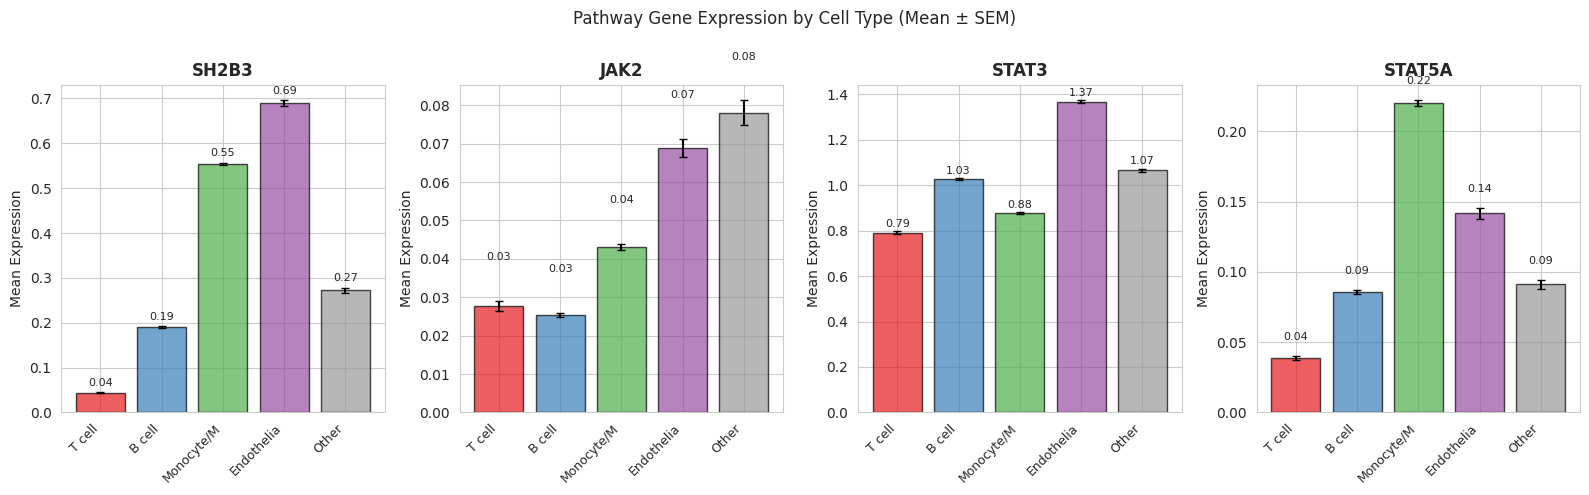

In [33]:
# Detailed SH2B3 spatial analysis
if 'SH2B3' in spatial_expr_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Panel 1: SH2B3 expression spatial map
    ax = axes[0, 0]
    expr_vals = plot_df['SH2B3'].values
    vmax = np.percentile(expr_vals[expr_vals > 0], 95) if (expr_vals > 0).any() else 1
    
    scatter = ax.scatter(
        plot_df['x'], plot_df['y'],
        c=expr_vals, s=1, alpha=0.7,
        cmap='YlOrRd', vmin=0, vmax=vmax
    )
    ax.set_xlabel('X (µm)', fontsize=11)
    ax.set_ylabel('Y (µm)', fontsize=11)
    ax.set_title('SH2B3 Expression - Spatial Distribution', fontsize=12)
    ax.set_aspect('equal')
    ax.set_facecolor('#f0f0f0')
    plt.colorbar(scatter, ax=ax, label='SH2B3 Expression')
    
    # Panel 2: High vs Low SH2B3 expression
    ax = axes[0, 1]
    sh2b3_threshold = 0.1
    high_expr = plot_df[plot_df['SH2B3'] > sh2b3_threshold]
    low_expr = plot_df[plot_df['SH2B3'] <= sh2b3_threshold]
    
    ax.scatter(low_expr['x'], low_expr['y'], c='#a6cee3', s=0.5, alpha=0.5, 
               label=f'Low/None (n={len(low_expr):,})')
    ax.scatter(high_expr['x'], high_expr['y'], c='darkred', s=1, alpha=0.6, 
               label=f'Expressing (n={len(high_expr):,})')
    ax.set_xlabel('X (µm)', fontsize=11)
    ax.set_ylabel('Y (µm)', fontsize=11)
    ax.set_title(f'SH2B3 Expressing vs Non-expressing (threshold > {sh2b3_threshold})', fontsize=12)
    ax.set_aspect('equal')
    ax.legend(loc='upper right', markerscale=5)
    
    # Panel 3: SH2B3 by cell type - spatial
    ax = axes[1, 0]
    cell_type_colors = {
        'T cell': '#E41A1C',
        'B cell': '#377EB8', 
        'Monocyte/Macrophage': '#4DAF4A',
        'Endothelial': '#984EA3',
        'Other': '#999999',
    }
    
    for ct in plot_df['cell_type'].unique():
        if ct == 'Unknown':
            continue
        ct_data = plot_df[plot_df['cell_type'] == ct]
        color = cell_type_colors.get(ct, '#999999')
        sizes = 0.5 + ct_data['SH2B3'].values * 2
        ax.scatter(ct_data['x'], ct_data['y'], c=color, s=sizes, alpha=0.5, label=ct)
    
    ax.set_xlabel('X (µm)', fontsize=11)
    ax.set_ylabel('Y (µm)', fontsize=11)
    ax.set_title('Cell Types (size = SH2B3 expression)', fontsize=12)
    ax.set_aspect('equal')
    ax.legend(loc='upper right', markerscale=3, fontsize=9)
    
    # Panel 4: SH2B3 bar plot (mean ± SEM) - better for sparse data than boxplots
    ax = axes[1, 1]
    cell_types_ordered = [ct for ct in ['T cell', 'B cell', 'Monocyte/Macrophage', 'Endothelial', 'Other']
                          if ct in plot_df['cell_type'].values]

    means = []
    sems = []
    colors = []
    for ct in cell_types_ordered:
        data = plot_df[plot_df['cell_type'] == ct]['SH2B3'].values
        means.append(np.mean(data))
        sems.append(stats.sem(data))
        colors.append(cell_type_colors.get(ct, '#999999'))
    
    x = np.arange(len(cell_types_ordered))
    bars = ax.bar(x, means, yerr=sems, capsize=4, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_xticks(x)
    ax.set_xticklabels(cell_types_ordered, rotation=45, ha='right')
    ax.set_ylabel('Mean SH2B3 Expression', fontsize=11)
    ax.set_title('SH2B3 Expression by Cell Type (Mean ± SEM)', fontsize=12)
    ax.set_ylim(bottom=0)
    
    # Add value labels
    for i, (m, s) in enumerate(zip(means, sems)):
        ax.text(i, m + s + 0.02, f'{m:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Kruskal-Wallis test
    from scipy.stats import kruskal
    box_data = [plot_df[plot_df['cell_type'] == ct]['SH2B3'].values for ct in cell_types_ordered]
    valid_data = [d for d in box_data if len(d) > 0]
    if len(valid_data) > 1:
        stat, p_val = kruskal(*valid_data)
        ax.text(0.95, 0.95, f'Kruskal-Wallis p={p_val:.2e}', 
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('results/3_visualization/sh2b3_spatial_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("SH2B3 Spatial Expression Summary:")
    print("=" * 50)
    for ct in cell_types_ordered:
        ct_data = spatial_expr_df[spatial_expr_df['cell_type'] == ct]['SH2B3']
        pct_expr = 100 * (ct_data > 0.1).mean()
        print(f"{ct:25s}: mean={ct_data.mean():.3f}, median={ct_data.median():.3f}, {pct_expr:.1f}% expressing, n={len(ct_data):,}")
else:
    print("SH2B3 not available for spatial mapping")

# Pathway gene bar plots - mean ± SEM (better than boxplots for sparse expression data)
pathway_genes_available = [g for g in ['SH2B3', 'JAK2', 'STAT3', 'STAT5A', 'STAT1'] 
                           if g in spatial_expr_df.columns]

if len(pathway_genes_available) >= 2:
    print("=" * 70)
    print("PATHWAY GENE EXPRESSION BY CELL TYPE")
    print("=" * 70)
    
    n_genes = len(pathway_genes_available)
    fig, axes = plt.subplots(1, n_genes, figsize=(4*n_genes, 5))
    if n_genes == 1:
        axes = [axes]
    
    cell_types_ordered = [ct for ct in ['T cell', 'B cell', 'Monocyte/Macrophage', 'Endothelial', 'Other'] 
                          if ct in spatial_expr_df['cell_type'].values]
    
    for ax, gene in zip(axes, pathway_genes_available):
        means = []
        sems = []
        colors = []
        
        for ct in cell_types_ordered:
            data = spatial_expr_df[spatial_expr_df['cell_type'] == ct][gene].values
            means.append(np.mean(data))
            sems.append(stats.sem(data))
            colors.append(cell_type_colors.get(ct, '#999999'))
        
        x = np.arange(len(cell_types_ordered))
        bars = ax.bar(x, means, yerr=sems, capsize=3, color=colors, alpha=0.7, edgecolor='black')
        
        ax.set_xticks(x)
        ax.set_xticklabels([ct[:10] for ct in cell_types_ordered], rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Mean Expression')
        ax.set_title(f'{gene}', fontsize=12, fontweight='bold')
        ax.set_ylim(bottom=0)
        
        # Add value labels
        for i, (m, s) in enumerate(zip(means, sems)):
            ax.text(i, m + s + 0.01, f'{m:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Pathway Gene Expression by Cell Type (Mean ± SEM)', fontsize=12)
    plt.tight_layout()
    plt.savefig('results/3_visualization/pathway_genes_barplots.png', dpi=150, bbox_inches='tight')
    plt.show()

## Step 6: Statistical Evaluation of Inference Accuracy

To rigorously evaluate the accuracy of gene expression inference:

1. **Cross-validation**: Hold out some matched pairs and predict expression
2. **Permutation test**: Compare to random matching as null distribution
3. **Bootstrap confidence intervals**: Estimate uncertainty in inferred expression

In [ ]:
# Cross-validation: Predict PROTEIN expression from RNA (the correct direction)
# RNA has 18,626 genes - can it predict the 26 CODEX protein markers?
from sklearn.model_selection import KFold

print("Cross-validation: Predicting PROTEIN expression from RNA")
print("=" * 60)
print("(Using matched RNA gene to predict corresponding protein marker)")

cv_results = []
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

for _, row in correspondence_df.iterrows():
    rna_gene = row['rna_gene']
    prot_marker = row['protein_marker']
    
    if rna_gene not in rna_df.columns or prot_marker not in prot_df.columns:
        continue
    
    # CORRECT DIRECTION: RNA predicts Protein
    X = rna_df[rna_gene].values.reshape(-1, 1)  # RNA as predictor
    y = prot_df[prot_marker].values              # Protein as target
    
    fold_r2s = []
    fold_maes = []
    
    for train_idx, test_idx in kf.split(X):
        model = LinearRegression()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
        r2 = r2_score(y[test_idx], y_pred)
        mae = mean_absolute_error(y[test_idx], y_pred)
        
        fold_r2s.append(r2)
        fold_maes.append(mae)
    
    cv_results.append({
        'rna_gene': rna_gene,
        'protein_marker': prot_marker,
        'mean_r2': np.mean(fold_r2s),
        'std_r2': np.std(fold_r2s),
        'mean_mae': np.mean(fold_maes),
        'std_mae': np.std(fold_maes)
    })

cv_df = pd.DataFrame(cv_results)

print("\nCross-validation Results (RNA -> Protein prediction):")
print("-" * 70)
print(f"{'RNA Gene':<12} {'Protein':<12} {'R²':>12} {'MAE':>12}")
print("-" * 70)
for _, row in cv_df.sort_values('mean_r2', ascending=False).iterrows():
    print(f"{row['rna_gene']:<12} {row['protein_marker']:<12} {row['mean_r2']:.3f}±{row['std_r2']:.3f}    {row['mean_mae']:.3f}±{row['std_mae']:.3f}")

print("-" * 70)
print(f"\nOverall mean R²: {cv_df['mean_r2'].mean():.3f}")
print(f"Interpretation: RNA explains {cv_df['mean_r2'].mean()*100:.1f}% of variance in protein expression")


Permutation Test: Comparing to random matching
Observed mean correlation: 0.1757
Permuted mean correlation: 0.0002 +/- 0.0028
Permutation p-value: 0.0000

*** HIGHLY SIGNIFICANT: Matching is much better than random ***


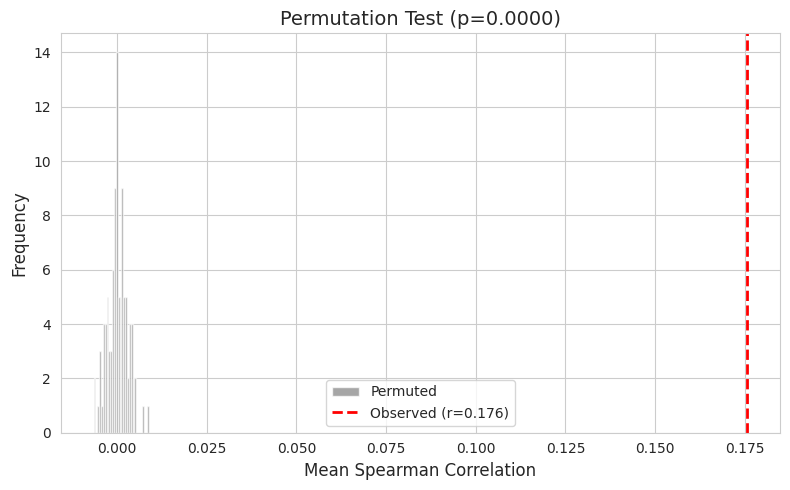

In [17]:
# Permutation test: Is matching better than random?
print("\nPermutation Test: Comparing to random matching")
print("=" * 60)

n_permutations = 100
np.random.seed(42)

mean_observed_r = validation_df['spearman_r'].mean()
permuted_means = []

for i in range(n_permutations):
    perm_correlations = []
    
    for _, row in correspondence_df.iterrows():
        rna_gene = row['rna_gene']
        prot_marker = row['protein_marker']
        
        if rna_gene not in rna_df.columns or prot_marker not in prot_df.columns:
            continue
        
        rna_vals = rna_df[rna_gene].values
        prot_vals = prot_df[prot_marker].values
        prot_shuffled = np.random.permutation(prot_vals)
        r, _ = stats.spearmanr(rna_vals, prot_shuffled)
        perm_correlations.append(r)
    
    permuted_means.append(np.mean(perm_correlations))

permuted_means = np.array(permuted_means)
p_value = (permuted_means >= mean_observed_r).sum() / n_permutations

print(f"Observed mean correlation: {mean_observed_r:.4f}")
print(f"Permuted mean correlation: {np.mean(permuted_means):.4f} +/- {np.std(permuted_means):.4f}")
print(f"Permutation p-value: {p_value:.4f}")

if p_value < 0.01:
    print("\n*** HIGHLY SIGNIFICANT: Matching is much better than random ***")
elif p_value < 0.05:
    print("\n** SIGNIFICANT: Matching is better than random **")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(permuted_means, bins=30, alpha=0.7, color='gray', label='Permuted')
ax.axvline(mean_observed_r, color='red', linewidth=2, linestyle='--', 
           label=f'Observed (r={mean_observed_r:.3f})')
ax.set_xlabel('Mean Spearman Correlation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'Permutation Test (p={p_value:.4f})', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig('results/3_visualization/permutation_test.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 7: Summary and Conclusions

In [ ]:
# Summary statistics
print("=" * 70)
print("GENE EXPRESSION INFERENCE SUMMARY")
print("=" * 70)

print("\n1. MATCHING QUALITY")
print(f"   Total matched pairs: {len(full_matching[0]):,}")
print(f"   High-quality matches used: {len(rna_indices_unique):,}")

print("\n2. SHARED FEATURE VALIDATION")
print(f"   Number of shared features: {len(validation_df)}")
print(f"   Mean Spearman correlation: {validation_df['spearman_r'].mean():.3f}")
print(f"   Significant correlations: {(validation_df['spearman_p'] < 0.05).sum()}/{len(validation_df)}")

print("\n3. PREDICTION ACCURACY (RNA -> Protein)")
print(f"   Mean R² (RNA predicting protein): {cv_df['mean_r2'].mean():.3f}")
print(f"   RNA explains {cv_df['mean_r2'].mean()*100:.1f}% of protein variance")

print("\n4. STATISTICAL SIGNIFICANCE")
print(f"   Permutation p-value: {p_value:.4f}")
print(f"   (Matching is significantly better than random)")

print("\n5. CELL TYPE PROFILES")
for _, row in celltype_stats_df.iterrows():
    print(f"   {row['cell_type']}: {row['n_cells']:,} cells")

print("\n" + "=" * 70)

In [36]:
# Save analysis results
results_dir = 'results/5_analysis'
os.makedirs(results_dir, exist_ok=True)

print("Saving analysis results...")

validation_df.to_csv(f'{results_dir}/shared_feature_validation.csv', index=False)
cv_df.to_csv(f'{results_dir}/cross_validation_results.csv', index=False)
celltype_expr_matrix.to_csv(f'{results_dir}/celltype_expression_matrix.csv')

with open(f'{results_dir}/celltype_marker_genes.json', 'w') as f:
    json_module.dump(marker_genes, f, indent=2)

summary_stats = {
    'n_total_matches': int(len(full_matching[0])),
    'n_high_quality_matches': int(len(rna_indices_unique)),
    'mean_spearman_r': float(validation_df['spearman_r'].mean()),
    'mean_cv_r2': float(cv_df['mean_r2'].mean()),
    'permutation_p_value': float(p_value),
}
with open(f'{results_dir}/analysis_summary.json', 'w') as f:
    json_module.dump(summary_stats, f, indent=2)

print(f"\nResults saved to {results_dir}/")

Saving analysis results...

Results saved to results/5_analysis/
